# Corrales et al. (2016), eLife - Fig. 1

## Introduction


To get started, we import a few modules needed for this notebook. From the standard library, we

for interacting with the filesystem. Furthermore we need to import modules from the PyTrack analysis library.

In [1]:
import sys
print(sys.version)
from pytrack_analysis.profile import *
from pytrack_analysis.database import *
from pytrack_analysis.logger import Logger
import pytrack_analysis.preprocessing as prep
from pytrack_analysis.kinematics import Kinematics
from pytrack_analysis.statistics import Statistics

3.6.1 (default, Apr  4 2017, 09:40:51) 
[GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)]


## Preliminaries

### Setting up a profile

In [2]:
### Setting up a profile

# import os module to interact with filesystem
import os
# get filename of this script
thisscript = "Notebook Fig. 1"
# get profile for project 'Vero eLife 2016' as user 'degoldschmidt'
profile = get_profile('Vero eLife 2016', 'degoldschmidt', script=thisscript)
# show the profile
show_profile(profile)

Loaded [PROJECT] Vero eLife 2016

$PROJECTS:
- Vero eLife 2016
$USERS:
- degoldschmidt

Vero eLife 2016:
  created: '2017-07-14 20:28:00'
  last active: '2017-08-10 07:36:09'
  systems:
    MacBook-Pro-3.local_degoldschmidt:
      database: /Users/degoldschmidt/Google Drive/PhD Project/Archive/VERO/vero_elife_2016/vero_elife_2016.txt
      log: /Users/degoldschmidt/Google Drive/PhD Project/Archive/VERO/vero_elife_2016_processing/main.log
      os: posix
      output: /Users/degoldschmidt/Google Drive/PhD Project/Archive/VERO/vero_elife_2016_processing
      plot: /Users/degoldschmidt/Google Drive/PhD Project/Archive/VERO/vero_elife_2016_processing/plots
      python: "3.6.1 (default, Apr  4 2017, 09:40:51) \n[GCC 4.2.1 Compatible Apple\
        \ LLVM 8.0.0 (clang-800.0.42.1)]"
      videos: /Users/degoldschmidt/Google Drive/PhD Project/Archive/VERO/Example Videos
    MacBook-Pro-3_x86_64_degoldschmidt:
      database: /Users/degoldschmidt/Google Drive/PhD Project/Archive/VERO/vero_eli

### Loading the database

Now, we want to load our database. The database class allows us to load file structure 

In [3]:
# get database from file
db = Database(get_db(profile))

STARTING DATA INTEGRITY TEST...
-------------------------------
CHECKING DATABASE...			[O.K.]
CHECKING METAFILES...			[O.K.]
CHECKING DATAFILES...			[O.K.]
CHECKING TIMESTAMPS...			[O.K.]


### Logging

In [4]:
# set up logger for this script
log = Logger(profile, scriptname=thisscript)

## Data Analysis

### Find session for Figure 1C & D (a bit of data exploration...)

First, we need to find which session correspond to the data shown in Fig. 1 C and D. From the original MATLAB scripts, I found that the video file "0003A01R01Cam03.avi" was used for analysis in Fig 1 C-D. The *database* class has a function called *find* to find sessions that match a key-value relation (here: key is "Videofilename" and value is "0003A01R01Cam03.avi").

In [5]:
# Print possible sessions with given video filename 
possible_sessions = db.find('Videofilename=0003A01R01Cam03.avi')
print(possible_sessions)

['CANS_004', 'CANS_005']


In [6]:
preview_data = []
# Since output gives two possibilities, we want to find out more about both sessions
for session in possible_sessions:
    this_session = db.session(session)
    # preview function gives subsampled raw data 
    preview_data.append(this_session.preview(subsampling=2))

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(color_codes=True) 
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("white")

In [8]:
def plot_2d(_data):
    fscale = 10
    if len(_data) == 2:
        fig, axes = plt.subplots(1, 2, figsize=(2*fscale,fscale))
    elif len(_data) == 1:
        fig, sax = plt.subplots(1, figsize=(fscale,fscale))
        axes = [sax]
    for i, ax in enumerate(axes):
        data = _data[i]
        ax.plot(data.loc[:,'head_x'], data.loc[:,'head_y'], 'k-', lw=1)
        ax.axis("equal")
        ax.axis("off")
        ax.set_title(possible_sessions[i]+":", fontsize=24, fontweight='bold', loc='left')
    return fig, axes

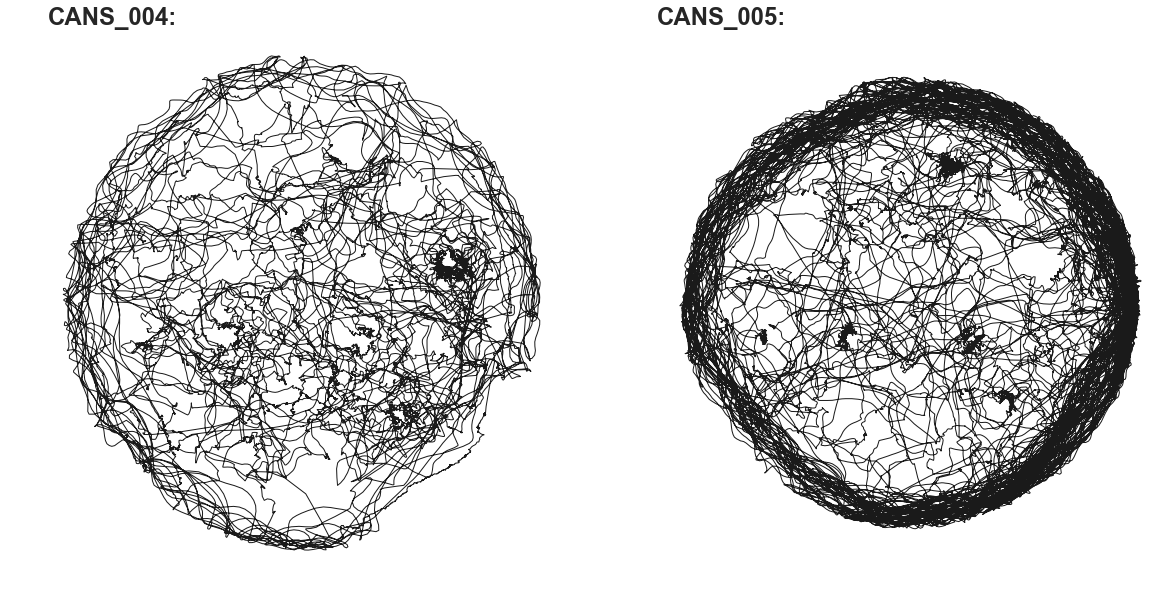

In [9]:
# plot 2d trajectory
fig, axes = plot_2d(preview_data)
# show the plot below
plt.show()

In [10]:
def plot_2d_patches(_data):
    fig, axes = plot_2d(_data)
    ### add food spots
    # colors (1: orange 2: blue, 3: white)
    patch_color = {1: '#ffc04c', 2: '#4c8bff', 3: '#ffffff'}
    for i, ax in enumerate(axes):
        # food patch positions (x, y)
        patch_positions = db.session(possible_sessions[i]).PatchPositions
        # food patch substrate type (1: yeast, 2: sucrose, 3: center/empty)
        patch_type = db.session(possible_sessions[i]).SubstrateType
        # food patch radius
        patch_radius = db.session(possible_sessions[i]).patch_radius
        # go through all patches
        for j, pos in enumerate(patch_positions):
            # get color for given patch
            c = patch_color[patch_type[j]]
            # define circle at position "pos" with radius "patch_radius"
            circle = plt.Circle(pos, patch_radius, color=c, alpha=0.5, zorder=10)
            # add circle to axis artist (draws the circle)
            ax.add_artist(circle)
    return fig, axes

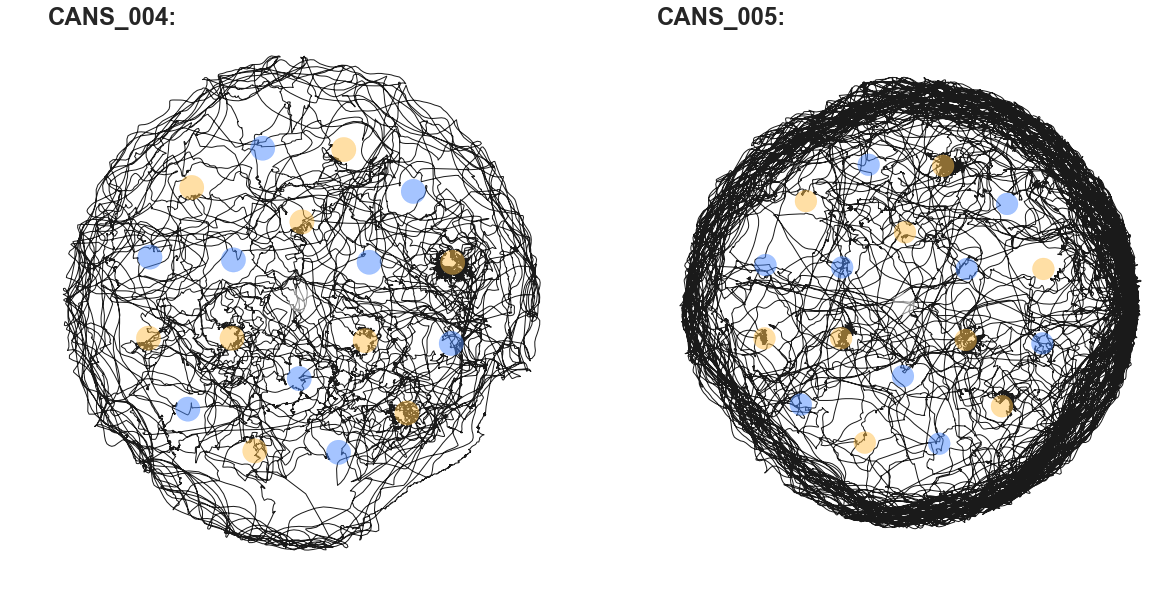

In [11]:
# plot 2d trajectory with color patches
fig, axes = plot_2d_patches(preview_data)
# show the plot below
plt.show()

In [12]:
def plot_2d_patches_zoom(_data):
    fig, axes = plot_2d_patches(_data)
    zoom = 90
    offsetx = 15
    offsety = -18
    for ax in axes:
        ax.set_xlim([-zoom+offsetx, zoom+offsetx])
        ax.set_ylim([-zoom+offsety, zoom+offsety])
    return fig, axes

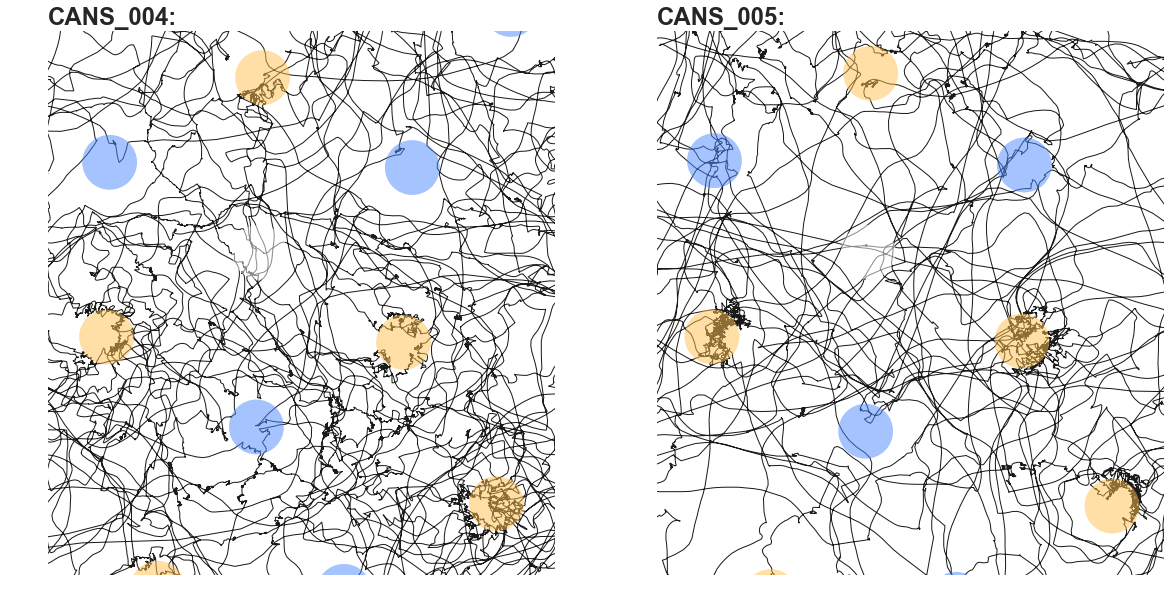

In [13]:
# plot zoomed 2d trajectory with color patches
fig, axes = plot_2d_patches_zoom(preview_data)
# show the plot below
plt.show()

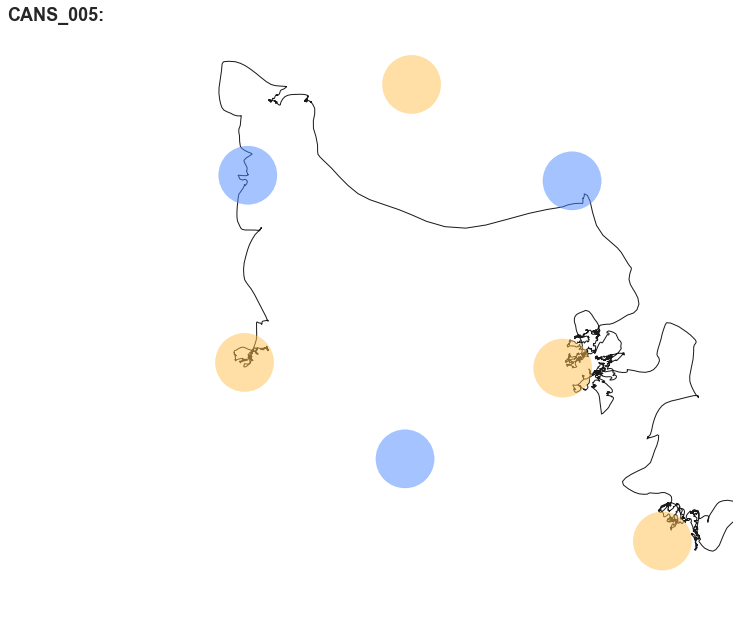

In [14]:
# cut data down to 3 mins (180 s * 50 frames/s = 9000 frames)
chosen = 1
start = 56100
end = start + 9000
short_data = [preview_data[chosen].loc[start:end,:]]

# plot zoomed 2d trajectory with color patches for given duration of time
fig, axes = plot_2d_patches_zoom(short_data)
axes[0].set_title(possible_sessions[chosen]+":", fontweight='bold', loc='left', x=-0.3, y=1.05)
# show the plot below
plt.show()

### Loading raw data and meta data from given session

In [15]:
# load session
this_session = db.session('CANS_005')
# load raw data and meta data
raw_data, meta_data = this_session.load()

In [16]:
## STEP 1: NaN removal + interpolation + px-to-mm conversion
clean_data = prep.interpolate(raw_data)
clean_data = prep.to_mm(clean_data, meta_data.px2mm)

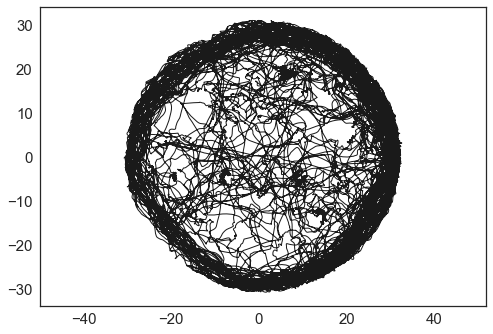

In [17]:
# plot zoomed 2d trajectory with color patches for given duration of time
plt.plot(clean_data['head_x'], clean_data['head_y'], 'k-', lw=1)
plt.axis("equal")
# show the plot below
plt.show()

In [18]:
## STEP 2: Gaussian filtering
window_len = 16 # = 0.32 s
smoothed_data = prep.gaussian_filter(clean_data, _len=window_len, _sigma=window_len/10)

In [19]:
## STEP 3: Distance from patch
kinematics = Kinematics(meta_data.dict)
distance_patch = kinematics.distance_to_patch(smoothed_data[['head_x', 'head_y']], meta_data)
print(distance_patch.columns)

Index(['dist_patch_0', 'dist_patch_1', 'dist_patch_10', 'dist_patch_11',
       'dist_patch_12', 'dist_patch_13', 'dist_patch_14', 'dist_patch_15',
       'dist_patch_16', 'dist_patch_17', 'dist_patch_18', 'dist_patch_2',
       'dist_patch_3', 'dist_patch_4', 'dist_patch_5', 'dist_patch_6',
       'dist_patch_7', 'dist_patch_8', 'dist_patch_9'],
      dtype='object')


In [20]:
## STEP 4: Linear Speed
speed = kinematics.linear_speed(smoothed_data, meta_data)
window_len = 60 # = 1.2 s
smooth_speed = prep.gaussian_filter(speed, _len=window_len, _sigma=window_len/10)
window_len = 120 # = 1.2 s
smoother_speed = prep.gaussian_filter(smooth_speed, _len=window_len, _sigma=window_len/10)
speeds = pd.DataFrame({"head": smooth_speed["head_speed"], "body": smooth_speed["body_speed"], "smoother_head": smoother_speed["head_speed"]})
print(speeds.head(10))

        body       head  smoother_head
0  38.169300  38.720431      14.739530
1  39.711602  40.295509      15.410502
2  40.318857  40.924523      16.030726
3  39.986854  40.602786      16.593830
4  38.790352  39.405544      17.094458
5  36.872433  37.477275      17.528406
6  34.424957  35.012014      17.892713
7  31.663618  32.228232      18.185723
8  28.801891  29.342575      18.407105
9  26.027986  26.546628      18.557834


In [21]:
## STEP 5: Angular Heading & Speed
angular_heading = kinematics.head_angle(smoothed_data)
angular_speed = kinematics.angular_speed(angular_heading, meta_data)

In [22]:
## STEP 7: Ethogram classification
etho_dict = {   0: "resting",
                1: "micromovement",
                2: "walking",
                3: "sharp turn",
                4: "yeast micromovement",
                5: "sucrose micromovement"}
meta_data.dict["etho_class"] = etho_dict
etho_vector, visits = kinematics.ethogram(speeds, angular_speed, distance_patch, meta_data)
print(etho_vector.head(10))

   etho
0   2.0
1   2.0
2   2.0
3   2.0
4   2.0
5   2.0
6   2.0
7   2.0
8   2.0
9   2.0


In [23]:
# closing and printing out last logging
log.close()
log.show()


Last log entry:

2017-08-10 07:36:09,955 - Notebook Fig. 1 - INFO - ==================================================
2017-08-10 07:36:09,955 - Notebook Fig. 1 - INFO - ===* STARTING SCRIPT: Notebook Fig. 1 *===
2017-08-10 07:36:09,956 - Notebook Fig. 1 - INFO - Timestamp: 2017-08-10 07:36:09
2017-08-10 07:36:09,956 - Notebook Fig. 1 - INFO - Part of project Vero eLife 2016 (current user: degoldschmidt)
2017-08-10 07:36:09,956 - Notebook Fig. 1 - INFO - Hosted @ MacBook-Pro-3_x86_64_degoldschmidt (OS: posix)
2017-08-10 07:36:09,956 - Notebook Fig. 1 - INFO - Python version: 3.6.1 (default, Apr  4 2017, 09:40:51) 
[GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)]
2017-08-10 07:36:18,257 - Kinematics.__init__ - INFO - initialized Kinematics pipeline (version: 0.0.3)
2017-08-10 07:36:18,266 - Kinematics.distance_to_patch - INFO - calling: distance_to_patch
2017-08-10 07:36:18,266 - Kinematics.distance_to_patch - INFO - takes arg: {'self': <class 'pytrack_analysis.kinematics.Kin

In [24]:
"""
if "Fig1" in DO_IT:
        ### Example session "CANS_005" for Fig 1C,D
        kine_analysis(db)

        ### Fig. E-H
        only_metab =  ["AA+ rich"]
        only_gene = ["Canton S"]
        group = db.sessions(genotype=only_gene, metabolic=only_metab)[:]
        for session in group:
            kine_analysis(db, _experiment=session.exp, _session=session.name, MULTI=True)
        num_mated, num_virgins = db.count(only_gene, ['Mated', 'Virgin'], only_metab)
        print( "Analyzed {1} mated {0} females and {2} virgin {0} females".format(db.last_select('Metabolic'), int(num_mated), int(num_virgins)) )
        stats_analysis(db, _only=group)


    figures = plotting(db)

    ### SAVE FIGURES TO FILE
    pltdir = get_plot(profile)
    for k,v in figures.items():
        figtitle = k + '.pdf'
        v[0].savefig(os.path.join(pltdir, figtitle), dpi=300)#v[0].dpi)
"""  
    

'\nif "Fig1" in DO_IT:\n        ### Example session "CANS_005" for Fig 1C,D\n        kine_analysis(db)\n\n        ### Fig. E-H\n        only_metab =  ["AA+ rich"]\n        only_gene = ["Canton S"]\n        group = db.sessions(genotype=only_gene, metabolic=only_metab)[:]\n        for session in group:\n            kine_analysis(db, _experiment=session.exp, _session=session.name, MULTI=True)\n        num_mated, num_virgins = db.count(only_gene, [\'Mated\', \'Virgin\'], only_metab)\n        print( "Analyzed {1} mated {0} females and {2} virgin {0} females".format(db.last_select(\'Metabolic\'), int(num_mated), int(num_virgins)) )\n        stats_analysis(db, _only=group)\n\n\n    figures = plotting(db)\n\n    ### SAVE FIGURES TO FILE\n    pltdir = get_plot(profile)\n    for k,v in figures.items():\n        figtitle = k + \'.pdf\'\n        v[0].savefig(os.path.join(pltdir, figtitle), dpi=300)#v[0].dpi)\n'